In [ ]:
import torch
import torch.nn.functional as F
from tqdm import tqdm
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from DELG_Class import DELG

class ImageRetrieval:
    def __init__(self, model_class, model_path, device, use_global=True, use_local=True):
        """
        model_class: class of the model (DELG or DELF)
        model_path: path to .pth file
        device: 'cuda' or 'cpu'
        use_global: whether the model produces global descriptors
        use_local: whether the model produces local descriptors
        """
        self.device = device
        self.use_global = use_global
        self.use_local = use_local

        # Initialize model
        self.model = model_class(
            pretrained=False,
            use_global=use_global,
            use_local=use_local
        ).to(device)
        
        # Load weights
        checkpoint = torch.load(model_path, map_location=device)
        if "model_state_dict" in checkpoint:
             state_dict = checkpoint["model_state_dict"]
        else:
            state_dict = checkpoint  # already raw weights

        self.model.load_state_dict(state_dict)
        self.model.eval()


        # Feature storage
        self.global_features = {}  # image_path -> global descriptor
        self.local_features = {}   # image_path -> local descriptors

    @torch.no_grad()
    def extract_features(self, image_loader):
        #Extract features for all images in a dataloader.
        for imgs, paths in tqdm(image_loader, desc="Extracting features"):
            imgs = imgs.to(self.device)
            feats = self.model(imgs)

            for i, path in enumerate(paths):
                if self.use_global and 'global' in feats:
                    self.global_features[path] = feats['global'][i].cpu().numpy()

                if self.use_local and 'local' in feats:
                    local_data = feats['local']
                    descriptors = local_data['descriptors'][i].cpu().numpy()

                    # Save keypoints if available
                    keypoints = None
                    if 'keypoints' in local_data:
                        keypoints = local_data['keypoints'][i].cpu().numpy()

                    self.local_features[path] = {
                        'descriptors': descriptors,
                        'keypoints': keypoints
                    }

    def save_features(self, file_path):
        """Save global and local features to disk."""
        np.savez_compressed(
            file_path,
            global_features=self.global_features,
            local_features=self.local_features
        )
        print(f"Features saved to {file_path}")
        

    def load_features(self, file_path):
        """Load previously saved features."""
        data = np.load(file_path, allow_pickle=True)
        self.global_features = data['global_features'].item()
        self.local_features = data['local_features'].item()
        print(f"Features loaded from {file_path}")


    def retrieve_global(self, query_feat, top_k=5):
        """Retrieve top-k candidates using global descriptors."""
        if not self.use_global:
            raise ValueError("This model cannot produce global descriptors.")

        all_feats = np.array(list(self.global_features.values()))
        all_paths = list(self.global_features.keys())
        sims = cosine_similarity(query_feat[None, :], all_feats)[0]
        top_idx = np.argsort(-sims)[:top_k]
        return [all_paths[i] for i in top_idx], sims[top_idx]

    def rerank_local(self, query_local, candidate_paths, top_k=5):
        """Re-rank top-k candidates using local descriptors."""
        if not self.use_local:
            raise ValueError("This model cannot produce local descriptors.")

        scores = []
        for path in candidate_paths:
            target_local = self.local_features[path]['descriptors'] #here
            sim_matrix = cosine_similarity(query_local, target_local)
            score = sim_matrix.max(axis=1).mean()  # max per query descriptor, then mean
            scores.append(score)

        sorted_idx = np.argsort(-np.array(scores))[:top_k]
        return [candidate_paths[i] for i in sorted_idx], np.array(scores)[sorted_idx]

    @torch.no_grad()
    def query(self, query_img, top_k=5, rerank_model=None):
        """
        query_img: torch tensor (1,3,H,W)
        top_k: number of results
        rerank_model: another ImageRetrieval instance (local descriptor for reranking)
        """
        query_img = query_img.to(self.device)
        feats = self.model(query_img)

        # Global retrieval
        if self.use_global and 'global' in feats:
            query_global = feats['global'][0].cpu().numpy()
            results, _ = self.retrieve_global(query_global, top_k=top_k)
        else:
            results = list(self.local_features.keys())[:top_k]

        # Local reranking
        if rerank_model is not None:
            query_local = feats['local']['descriptors'][0].cpu().numpy()
            results, _ = rerank_model.rerank_local(query_local, results, top_k=top_k)

        return results


# Data Preparation

In [2]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms
import os

class ImageFolderDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.image_paths = [os.path.join(root_dir, f) 
                            for f in os.listdir(root_dir) 
                            if f.lower().endswith((".jpg", ".png", ".jpeg"))]
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        path = self.image_paths[idx]
        img = Image.open(path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, path

# Transforms
transform = transforms.Compose([
    transforms.Resize((224,224)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

# Dataset & DataLoader
dataset = ImageFolderDataset("dataset", transform=transform)
loader = DataLoader(dataset, batch_size=16, shuffle=False)


# DELG fine tune global / freeze local

In [111]:
delg_retriever = ImageRetrieval(
    model_class=DELG,      
    model_path="allModel/delg_global_finetune_local_pretrained.pth",    
    device="cuda",
    use_global=True,        
    use_local=True        
)

#delg_retriever.extract_features(loader)
# Save the extracted features
#delg_retriever.save_features("features/delg_global_finetune_local_pretrained_features.npz")


C:\Users\Phumi\AppData\Local\Temp\ipykernel_1676\2534728426.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9481792..2.64].


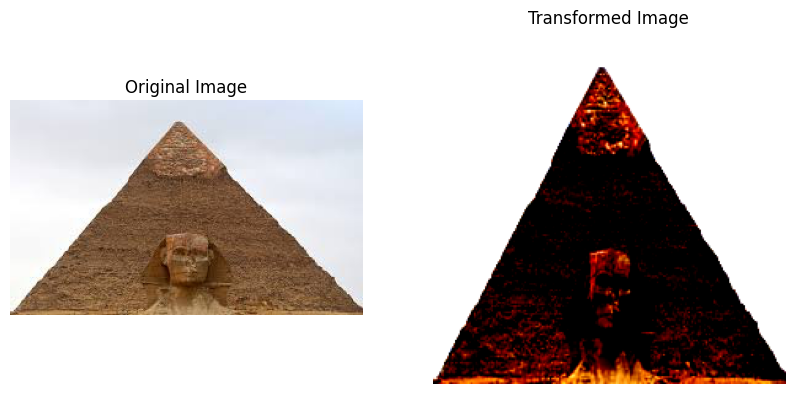

In [104]:
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from PIL import Image

# Load query image
img_path = "images.jpg"
img = Image.open(img_path).convert("RGB")

# Define transform (match model input)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Apply transform and add batch dimension
query_img = transform(img).unsqueeze(0)  # shape [1,3,224,224]

# Denormalize for plotting
#mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
#std = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
#img_plot = query_img.squeeze(0) * std + mean  # undo normalization
#img_plot = torch.clamp(img_plot, 0, 1)       # ensure values in [0,1]

# Plot side by side
plt.figure(figsize=(10,5))

# Original image
plt.subplot(1,2,1)
plt.imshow(img)
plt.axis('off')
plt.title("Original Image")

# Transformed image
plt.subplot(1,2,2)
#plt.imshow(img_plot.permute(1, 2, 0).numpy())
plt.imshow(query_img.squeeze(0).permute(1, 2, 0).detach().numpy())
plt.axis('off')
plt.title("Transformed Image")

plt.show()


Features loaded from features/delg_global_finetune_local_pretrained_features.npz
Top-5 retrieved images: ['dataset\\train_Pyramids Of Giza - Egypt_1774.jpg', 'dataset\\train_Pyramids Of Giza - Egypt_1837.jpg', 'dataset\\train_Pyramids Of Giza - Egypt_1840.jpg', 'dataset\\train_Pyramids Of Giza - Egypt_1813.jpg', 'dataset\\train_Pyramids Of Giza - Egypt_1702.jpg']


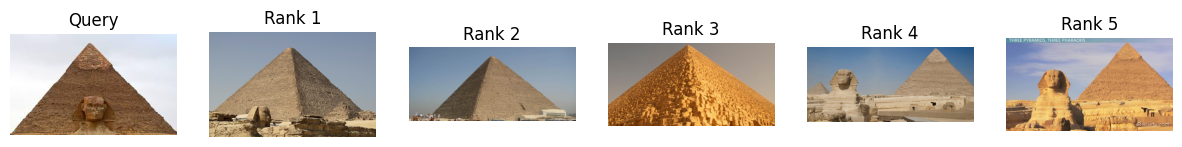

In [112]:
#load previously saved features
delg_retriever.load_features("features/delg_global_finetune_local_pretrained_features.npz")

# Run retrieval
results = delg_retriever.query(query_img, top_k=5)
print("Top-5 retrieved images:", results)

# Plot query and top-5 results
plt.figure(figsize=(15,5))

# Original query
plt.subplot(1, 6, 1)
plt.imshow(img)
plt.axis('off')
plt.title("Query")

# Retrieved images
for i, path in enumerate(results):
    retrieved_img = Image.open(path).convert("RGB")
    plt.subplot(1, 6, i+2)
    plt.imshow(retrieved_img)
    plt.axis('off')
    plt.title(f"Rank {i+1}")

plt.show()

# DELG Local Correspondences

In [96]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

def visualize_local_matches(query_local, retrieved_local, query_img, retrieved_img, max_matches=50):
    q_desc = query_local['descriptors'].astype(np.float32)
    r_desc = retrieved_local['descriptors'].astype(np.float32)
    q_kp = query_local['keypoints']
    r_kp = retrieved_local['keypoints']

    if q_kp is None or r_kp is None:
        print("⚠️ Keypoints missing — cannot show true correspondences.")
        return

    q_kp_cv = [cv2.KeyPoint(float(x), float(y), 1) for (x, y) in q_kp]
    r_kp_cv = [cv2.KeyPoint(float(x), float(y), 1) for (x, y) in r_kp]

    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    matches = bf.match(q_desc, r_desc)
    matches = sorted(matches, key=lambda x: x.distance)[:max_matches]

    img1 = np.array(query_img)[:, :, ::-1]
    img2 = np.array(retrieved_img)[:, :, ::-1]

    matched_img = cv2.drawMatches(img1, q_kp_cv, img2, r_kp_cv, matches, None,
                                  flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    plt.figure(figsize=(15, 8))
    plt.imshow(cv2.cvtColor(matched_img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title(f"Local Feature Correspondences ({len(matches)} matches)")
    plt.show()



In [97]:
delg_retriever.load_features("features/delg_global_finetune_local_pretrained_features.npz")
query_local = delg_retriever.local_features['dataset\\train_Pyramids Of Giza - Egypt_1742.jpg']
retrieved_local = delg_retriever.local_features[results[0]]  # top-1 result

visualize_local_matches(query_local, retrieved_local, img, Image.open(results[0]).convert("RGB"))



Features loaded from features/delg_global_finetune_local_pretrained_features.npz
⚠️ Keypoints missing — cannot show true correspondences.


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

def visualize_attention(model, img_tensor, orig_img):
    """Visualize DELG global attention heatmap (if available)."""
    model.eval()
    device = next(model.parameters()).device
    with torch.no_grad():
        feats = model(img_tensor.to(device))

    if 'attention' not in feats:
        print("No attention map available for this model.")
        return

    attn = feats['attention'][0].cpu().numpy()
    if attn.ndim == 3:
        attn = attn.squeeze()  # ensure 2D

    # Normalize
    attn = (attn - attn.min()) / (attn.max() - attn.min() + 1e-8)

    # Resize to original image size
    attn_resized = cv2.resize(attn, (orig_img.width, orig_img.height))

    # Convert original image to array
    orig_array = np.array(orig_img)
    if orig_array.dtype != np.uint8:
        orig_array = (orig_array * 255).astype(np.uint8)

    # Apply heatmap
    heatmap = cv2.applyColorMap(np.uint8(255 * attn_resized), cv2.COLORMAP_JET)
    blended = cv2.addWeighted(orig_array, 0.6, heatmap, 0.4, 0)

    # Plot
    plt.figure(figsize=(6, 6))
    plt.imshow(blended)
    plt.axis('off')
    plt.title("Global Attention Heatmap")
    plt.show()


In [ ]:
visualize_attention(delg_retriever.model, query_img, orig_img)


In [98]:
delg_retriever = ImageRetrieval(
    model_class=DELG,      
    model_path="allModel/delg_global_finetune_no_local.pth",    
    device="cuda",
    use_global=True,        
    use_local=False        
)

delg_retriever.extract_features(loader)
# Save the extracted features
delg_retriever.save_features("features/delg_global_finetune_no_local_features.npz")


c:\Users\Phumi\anaconda3\envs\yolo\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Phumi\anaconda3\envs\yolo\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\Phumi\AppData\Local\Temp\ipykernel_1676\2534728426.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_

Features saved to features/delg_global_finetune_no_local_features.npz


In [ ]:
delg_retriever = ImageRetrieval(
    model_class=DELG,      
    model_path="allModel/delf_local_backbone_finetune.pth",    
    device="cuda",
    use_global=False,        
    use_local=True        
)

delg_retriever.extract_features(loader)
# Save the extracted features
delg_retriever.save_features("features/delf_local_backbone_finetune_features.npz")

C:\Users\Phumi\AppData\Local\Temp\ipykernel_1676\2534728426.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)
Ext

Features saved to features/delf_local_backbone_finetune.pth_features.npz


In [115]:
delg_retriever = ImageRetrieval(
    model_class=DELG,      
    model_path="allModel/delg_both_pretrained.pth",    
    device="cuda",
    use_global=True,        
    use_local=True        
)

delg_retriever.extract_features(loader)
# Save the extracted features
delg_retriever.save_features("features/delg_both_pretrained_features.npz")

c:\Users\Phumi\anaconda3\envs\yolo\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Phumi\anaconda3\envs\yolo\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\Phumi\AppData\Local\Temp\ipykernel_1676\2534728426.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_

Features saved to features/delg_both_pretrained_features.npz


In [116]:

delg_retriever = ImageRetrieval(
    model_class=DELG,      
    model_path="allModel/delg_global_finetune_local_pretrained_keypoints.pth",    
    device="cuda",
    use_global=True,        
    use_local=True        
)

delg_retriever.extract_features(loader)
# Save the extracted features
delg_retriever.save_features("delg_global_finetune_local_pretrained_keypoints_features.npz")


C:\Users\Phumi\AppData\Local\Temp\ipykernel_1676\2534728426.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)
Ext

Features saved to delg_global_finetune_local_pretrained_keypoints_features.npz


In [8]:
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

delg_retriever = ImageRetrieval(
    model_class=DELG,      
    model_path="allModel/delg_global_finetune_local_pretrained_attentions.pth",    
    device="cuda",
    use_global=True,        
    use_local=True        
)

delg_retriever.extract_features(loader)
# Save the extracted features
delg_retriever.save_features("features/delg_global_finetune_local_pretrained_attentions_features.npz")



C:\Users\Phumi\AppData\Local\Temp\ipykernel_17700\3289829653.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)
Ex

Features saved to features/delg_global_finetune_local_pretrained_attentions_features.npz


In [118]:
import numpy as np

# Load the .npz file
data = np.load("features/delg_global_finetune_local_pretrained_attentions_features.npz", allow_pickle=True)

# Check keys
print("Keys in the file:", data.keys())

# Access global and local features
global_features = data['global_features'].item()
local_features = data['local_features'].item()

# Print some information
print("Number of images with global features:", len(global_features))
print("Number of images with local features:", len(local_features))

# Print a sample
sample_image = list(global_features.keys())[0]
print("Sample image:", sample_image)
print("Global descriptor shape:", global_features[sample_image].shape)

sample_image_local = list(local_features.keys())[0]
print("Local descriptor keys for sample image:", local_features[sample_image_local].keys())
print("Local descriptors shape:", local_features[sample_image_local]['descriptors'].shape)
print("Local keypoints shape:", local_features[sample_image_local]['keypoints'].shape if local_features[sample_image_local]['keypoints'] is not None else None)


Keys in the file: KeysView(NpzFile 'features/delg_global_finetune_local_pretrained_attentions_features.npz' with keys: global_features, local_features)
Number of images with global features: 2872
Number of images with local features: 2872
Sample image: dataset\train_Antarctica_0.jpg
Global descriptor shape: (2048,)
Local descriptor keys for sample image: dict_keys(['descriptors', 'keypoints'])
Local descriptors shape: (49, 2048)
Local keypoints shape: None
